# Test medical imaging

## Test datasets processing

### Test TCIA processing

In [43]:

# Copyright (C) 2022 Langlois Quentin, UCLouvain, INGI. All rights reserved.
# Licenced under the Affero GPL v3 Licence (the "Licence").
# you may not use this file except in compliance with the License.
# See the "LICENCE" file at the root of the directory for the licence information.
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import glob
import json
import logging
import numpy as np
import pandas as pd
import tensorflow as tf

from tqdm import tqdm

from loggers import timer
from utils.file_utils import load_json, dump_json
from datasets.custom_datasets import get_dataset_dir

logger = logging.getLogger(__name__)

TCIA_DIR = '{}/TCIA'.format(get_dataset_dir())

IMAGE_SEGMENTATION = 'Organ segmentation'

def image_seg_dataset_wrapper(name, task, ** default_config):
    def wrapper(dataset_loader):
        """
            Wrapper for EEG datasets.
            The returned dataset is expected to be a `pd.DataFrame` with columns :
                - eeg      : 2-D np.ndarray (the EEG signal)
                - channels : the position's name for the electrodes (list, same length as eeg)
                - rate     : the default EEG sampling rate
                - id       : the subject's id (if not provided, set to the dataset's name)
                - label    : the expected label (the task performed / simulated or the stimuli, ...)
            The wrapper adds the keys :
                - n_channels    : equivalent to len(pos), the number of eeg channels (electrodes)
                - time      : the session's time (equivalent to the signal's length divided by rate)
                
        """
        @timer(name = '{} loading'.format(name))
        def _load_and_process(directory, * args, per_user_label = False, keep_artifacts = False, keep_passive = True, ** kwargs):
            return dataset_loader(directory, * args, ** kwargs)
        
        from datasets.custom_datasets import add_dataset
        
        fn = _load_and_process
        fn.__name__ = dataset_loader.__name__
        fn.__doc__  = dataset_loader.__doc__
        
        add_dataset(name, processing_fn = fn, task = task, ** default_config)
        
        return fn
    return wrapper

def preprocess_tcia_annots(directory, metadata_file = 'metadata.json', overwrite = False, tqdm = lambda x: x, ** kwargs):
    def parse_serie(path, serie_num = -1):
        dirs = sorted(os.listdir(path), key = lambda d: len(os.listdir(os.path.join(path, d))))
        if len(dirs) == 1:
            raise RuntimeError('Unknown annotation type, only 1 directory for serie path {}'.format(path))

        seg_dirs, imgs_dir = dirs[:-1], os.path.join(path, dirs[-1])

        segmentations_infos = []
        for seg_dir in seg_dirs:
            seg_files = os.listdir(os.path.join(path, seg_dir))
            if len(seg_files) != 1:
                raise RuntimeError('{} annotation files for path {}'.format(os.path.join(path, seg_dir)))
            seg_file = os.path.join(path, seg_dir, seg_files[0])
            
            if seg_file not in all_segs_infos:
                with dcm.dcmread(seg_file) as seg:
                    if hasattr(seg, 'StructureSetROISequence'):
                        organs = [struct.ROIName for struct in seg.StructureSetROISequence]
                    elif hasattr(seg, 'SegmentSequence'):
                        organs = [s.SegmentDescription for s in seg.SegmentSequence]
                    else:
                        raise RuntimeError('Unknown annotation sequence name for file {} :\n{}'.format(seg_file, seg))
                    
                    all_segs_infos[seg_file] = {
                        'id'      : str(seg.PatientName),
                        'sex'     : str(seg.PatientSex),
                        'organs'  : organs
                    }

            patient_id  = all_segs_infos[seg_file]['id']
            patient_sex = all_segs_infos[seg_file]['sex']
            organs      = all_segs_infos[seg_file]['organs']
            
            segmentations_infos.append({
                'subject_id'      : patient_id,
                'serie'           : serie_num,
                'segmentation_id' : seg_dir,
                'sex'             : patient_sex,
                'images_dir'      : imgs_dir,
                'nb_images'       : len(os.listdir(imgs_dir)),
                'images'          : [os.path.join(imgs_dir, f) for f in os.listdir(imgs_dir)],
                'segmentation'    : seg_file,
                'organs'          : organs
            })
        
        return segmentations_infos

    def parse_client(client_dir):
        series = []
        for i, serie_dir in enumerate(os.listdir(client_dir)):
            series.extend(parse_serie(os.path.join(client_dir, serie_dir), i))
        return series
    
    import pydicom as dcm

    data_dir = [os.path.join(directory, d) for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    if len(data_dir) != 1:
        raise RuntimeError('{} data dirs in {} :\n{}'.format(len(main_dir), directory, '\n'.join(main_dir)))
    data_dir = data_dir[0]
    
    all_segs_infos = {}
    if not overwrite and metadata_file:
        all_segs_infos = load_json(os.path.join(directory, metadata_file))

    metadata = []
    for client_dir in tqdm(os.listdir(data_dir)):
        client_dir = os.path.join(data_dir, client_dir)
        if os.path.isdir(client_dir): metadata.extend(parse_client(client_dir))
    
    if metadata_file: dump_json(filename = os.path.join(directory, metadata_file), data = all_segs_infos, indent = 4)
    
    return pd.DataFrame(metadata)

if os.path.exists(TCIA_DIR):
    for manifest_dir in os.listdir(TCIA_DIR):
        image_seg_dataset_wrapper(
            name      = [d for d in os.listdir(os.path.join(TCIA_DIR, manifest_dir)) if os.path.isdir(os.path.join(TCIA_DIR, manifest_dir, d))][0],
            task      = IMAGE_SEGMENTATION,
            directory = os.path.join(TCIA_DIR, manifest_dir)
        )(preprocess_tcia_annots)


100%|████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 11538.40it/s]


{
    "Heart": 60,
    "Esophagus": 60,
    "Lung_R": 60,
    "Lung_L": 60,
    "SpinalCord": 60
}


100%|█████████████████████████████████████████████████████████████████████████████████| 423/423 [04:47<00:00,  1.47it/s]


{
    "Esophagus": 710,
    "GTV-1": 842,
    "Heart": 254,
    "Lung-Left": 624,
    "Lung-Right": 624,
    "Spinal-Cord": 822,
    "gtv-3": 23,
    "gtv-2": 218,
    "gtv-pre-op": 1,
    "gtv-pre-operat": 1,
    "Lungs-Total": 194,
    "gtv_lnn": 1,
    "gtv_4r": 5,
    "gtv7": 2,
    "gtv10l": 1,
    "gtv2r": 1,
    "gtv5": 1,
    "gtv6": 1,
    "gtv-4": 9,
    "gtv-2r": 1,
    "gtv-6": 2,
    "gtv-7": 1,
    "gtv-5": 3,
    "gtv_supraclav": 1,
    "gtv_5": 2,
    "gtv-sum": 1,
    "gtv_10_li": 1,
    "gtv_nr_7": 1,
    "gtv__2_re": 1,
    "gtv_2_re_2": 1,
    "gtv_10r": 2,
    "gtv_10_re": 1,
    "gtv_supra_re": 1,
    "gtv_2r": 2,
    "gtv_7": 3,
    "gtv_2l": 2,
    "gtv-r": 1,
    "gtv_sup_re": 1,
    "gtv_2": 1,
    "gtv_2_r": 1,
    "gtv2": 2,
    "gtv-ntotal": 1,
    "gtv3": 1,
    "gtv-3_2l2": 1,
    "gtv-2_4r": 1,
    "gtv-4l": 1,
    "gtv-supral": 1,
    "gtv-2l": 1,
    "gtv_4_r": 1,
    "gtv_11_r": 1,
    "gtv_10_r": 2,
    "gtv_2_l_r": 1,
    "gtv_5-6": 1,
    "gtv_10_l

100%|███████████████████████████████████████████████████████████████████████████████| 360/360 [00:00<00:00, 7351.19it/s]

{
    "UteroCervix": 357,
    "Thymus": 358,
    "Stomach": 359,
    "Spleen": 359,
    "Spinal Canal": 359,
    "Small Intestine": 359,
    "Rectum": 358,
    "Prostate": 357,
    "Pancreas": 358,
    "Liver": 359,
    "Large Intestine": 359,
    "Kidney Right": 357,
    "Kidney Left": 359,
    "Heart": 359,
    "Gonads": 358,
    "Gall Bladder": 358,
    "Femoral Head Rig": 359,
    "Femoral Head Lef": 358,
    "Esophagus": 359,
    "Duodenum": 358,
    "Breast Right": 357,
    "Breast Left": 358,
    "Bladder": 358,
    "Adrenal Right": 358,
    "Adrenal Left": 358,
    "Lung_R": 357,
    "Lung_L": 357,
    "Skin": 359,
    "Bones": 358,
    "Lung_L1": 4,
    "Lung_R1": 4,
    "BODY": 6,
    "Bones1": 4,
    "Horseshoe Kidney": 1,
    "Rt Adrenal": 1,
    "Lt Adrenal": 1,
    "Skin1": 1
}


In [ ]:
for manifest in os.listdir(TCIA_DIR):
    df = preprocess_tcia_annots(os.path.join(TCIA_DIR, manifest), tqdm = tqdm, overwrite = False)
    df = pd.DataFrame(df)
    counts = {}
    for organs in df['organs'].values:
        for o in organs:
            counts.setdefault(o, 0)
            counts[o] += 1
    print(json.dumps(counts, indent = 4))

In [40]:
import pydicom as dcm

file = '/storage/TCIA/manifest-1603198545583/NSCLC-Radiomics/LUNG1-011/01-01-2014-StudyID-NA-64935/300.000000-Segmentation-575.3/1-1.dcm'
print(len(os.listdir(os.path.dirname(file))))
with dcm.dcmread(file) as ds:
    print(ds.dir('alu'))
    for s in ds.SegmentSequence:
        print(s.SegmentDescription)
        print(s.dir('abe'))
        print(s)
        
    #print(ds.SegmentSequence)
    #print(ds)

1
[]
Esophagus
['SegmentLabel']
(0062, 0003)  Segmented Property Category Code Sequence  1 item(s) ---- 
   (0008, 0100) Code Value                          SH: '123037004'
   (0008, 0102) Coding Scheme Designator            SH: 'SCT'
   (0008, 0104) Code Meaning                        LO: 'Anatomical Structure'
   ---------
(0062, 0004) Segment Number                      US: 1
(0062, 0005) Segment Label                       LO: 'Esophagus'
(0062, 0006) Segment Description                 ST: 'Esophagus'
(0062, 0008) Segment Algorithm Type              CS: 'MANUAL'
(0062, 000d) Recommended Display CIELab Value    US: [47752, 35625, 38020]
(0062, 000f)  Segmented Property Type Code Sequence  1 item(s) ---- 
   (0008, 0100) Code Value                          SH: '32849002'
   (0008, 0102) Coding Scheme Designator            SH: 'SCT'
   (0008, 0104) Code Meaning                        LO: 'Esophagus'
   ---------
GTV-1
['SegmentLabel']
(0008, 2218)  Anatomic Region Sequence  1 item(s)

### Integration with the `datasets` module

In [1]:
from datasets import print_datasets, get_dataset

print_datasets()

2023-03-15 10:27:15.370380: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-15 10:27:15.464602: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-15 10:27:15.489569: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/etinfo/users2/qlanglois/.local/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is requir

Task tts :	('siwis', 'voxforge', 'common_voice', 'mls', 'librispeech', 'identification')
Task stt :	('siwis', 'voxforge', 'common_voice', 'mls', 'librispeech', 'identification')
Task object classification :	('image_directory',)
Task face recognition :	('essex', 'celeba', 'tdface', 'youtube_faces')
Task object detection :	('youtube_faces', 'wider', 'voc', 'coco', 'fungi', 'kangaroo', 'raccoon')
Task object segmentation :	('coco',)
Task image captioning :	('coco',)
Task image generation :	('anime_faces',)
Task Q&A (English) :	('coqa', 'nq', 'newsqa', 'qangaroo', 'squad', 'triviaqa')
Task Translation :	('europarl',)
Task Text comparison :	('parade', 'paws', 'qqp', 'snli', 'sts')
Task Q&A (French) :	('french_squad', 'fquad', 'piaf')
Task BCI :	('bci-iv_2a', 'brain_mnist', 'eegmmidb', 'large_scale_bci')
Task EEG emotion recognition :	('seed',)
Task Organ segmentation :	('lctsc', 'nsclc-radiomics', 'pediatric-ct-seg')
Available keras datasets : ['cifar10', 'cifar100', 'fashion_mnist', 'imdb'

In [ ]:
from tqdm import tqdm

from datasets import get_dataset

df = get_dataset('nsclc-radiomics', overwrite = False, tqdm = tqdm)
df

## Test plots

### Data loading + analysis

In [16]:
import numpy as np
import pydicom as dcm

from datasets import get_dataset
from utils import plot, plot_multiple

datasets = ['pediatric-ct-seg', 'lctsc', 'nsclc-radiomics']

df = get_dataset('lctsc')
df.head()

Loading dataset lctsc...


,subject_id,serie,segmentation_id,sex,images_dir,nb_images,images,segmentation,organs
0,LCTSC-Test-S3-102,0,1.000000-.simplified-02503,F,/storage/TCIA/manifest-1557326747206/LCTSC/LCT...,210,[/storage/TCIA/manifest-1557326747206/LCTSC/LC...,/storage/TCIA/manifest-1557326747206/LCTSC/LCT...,"[Heart, Esophagus, Lung_R, Lung_L, SpinalCord]"
1,LCTSC-Train-S3-009,0,1.000000-.simplified-46378,F,/storage/TCIA/manifest-1557326747206/LCTSC/LCT...,115,[/storage/TCIA/manifest-1557326747206/LCTSC/LC...,/storage/TCIA/manifest-1557326747206/LCTSC/LCT...,"[Esophagus, Heart, SpinalCord, Lung_L, Lung_R]"
2,LCTSC-Test-S3-103,0,1.000000-.simplified-29555,F,/storage/TCIA/manifest-1557326747206/LCTSC/LCT...,136,[/storage/TCIA/manifest-1557326747206/LCTSC/LC...,/storage/TCIA/manifest-1557326747206/LCTSC/LCT...,"[Esophagus, Heart, SpinalCord, Lung_L, Lung_R]"
3,LCTSC-Train-S3-010,0,1.000000-.simplified-76637,F,/storage/TCIA/manifest-1557326747206/LCTSC/LCT...,150,[/storage/TCIA/manifest-1557326747206/LCTSC/LC...,/storage/TCIA/manifest-1557326747206/LCTSC/LCT...,"[Esophagus, Heart, SpinalCord, Lung_L, Lung_R]"
4,LCTSC-Test-S3-104,0,1.000000-.simplified-93010,F,/storage/TCIA/manifest-1557326747206/LCTSC/LCT...,165,[/storage/TCIA/manifest-1557326747206/LCTSC/LC...,/storage/TCIA/manifest-1557326747206/LCTSC/LCT...,"[Esophagus, Heart, SpinalCord, Lung_L, Lung_R]"


In [5]:
seg_file = df.loc[0, 'segmentation']

ds = dcm.dcmread(seg_file)

print(ds.PatientName)
print(ds.SeriesNumber)
print(ds.PatientSex)
print(ds.PatientBirthDate)

Pediatric-CT-SEG-02BA6CE5
2




### 2D scan plots

In [ ]:
import math

n = 25
for i in range(5):
    print(df.loc[i])
    frames = df.loc[i, 'images']

    plot_multiple(** {
        'Frame #{}'.format(i) : dcm.dcmread(f).pixel_array for i, f in enumerate(frames[::len(frames) // n][:n])
    }, plot_type = 'imshow', ncols = int(math.sqrt(n)))

### 2D scan + label plots

subject_id                                         LCTSC-Test-S3-102
serie                                                              0
segmentation_id                           1.000000-.simplified-02503
sex                                                                F
images_dir         /storage/TCIA/manifest-1557326747206/LCTSC/LCT...
nb_images                                                        210
images             [/storage/TCIA/manifest-1557326747206/LCTSC/LC...
segmentation       /storage/TCIA/manifest-1557326747206/LCTSC/LCT...
organs                [Heart, Esophagus, Lung_R, Lung_L, SpinalCord]
Name: 0, dtype: object
(512, 512, 16)
(512, 512, 16)
(512, 512, 16)
(512, 512, 16)
(512, 512, 16)
0
(512, 512) (512, 512, 4)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


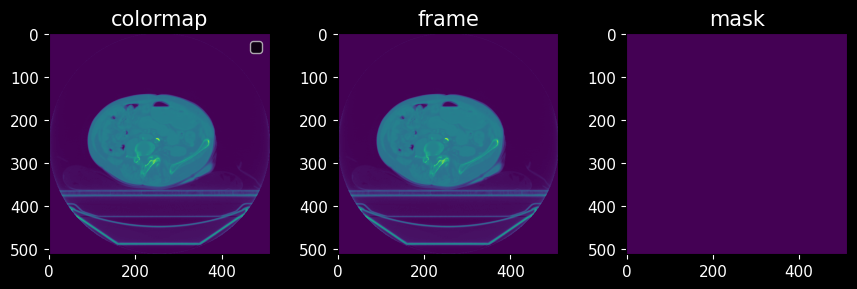

3
(512, 512) (512, 512, 4)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


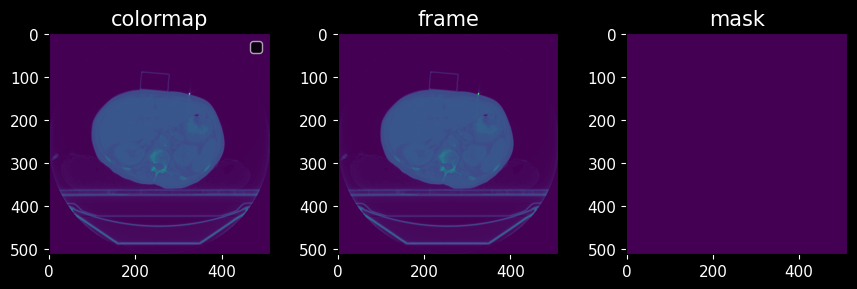

6
(512, 512) (512, 512, 4)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


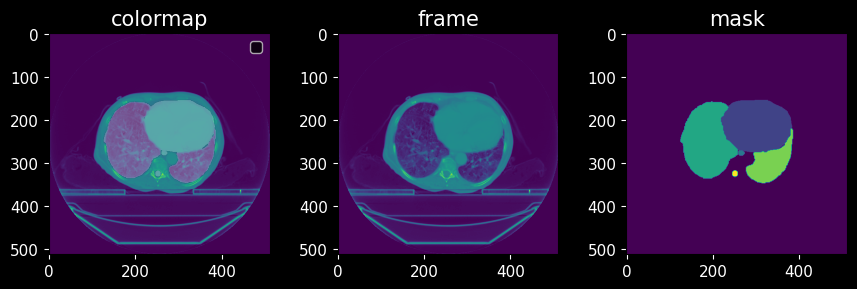

9
(512, 512) (512, 512, 4)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


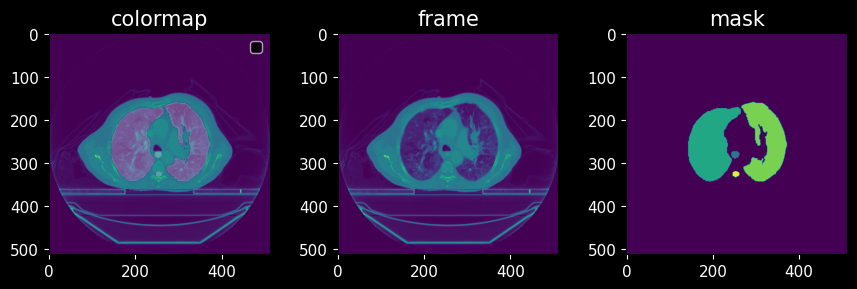

12
(512, 512) (512, 512, 4)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


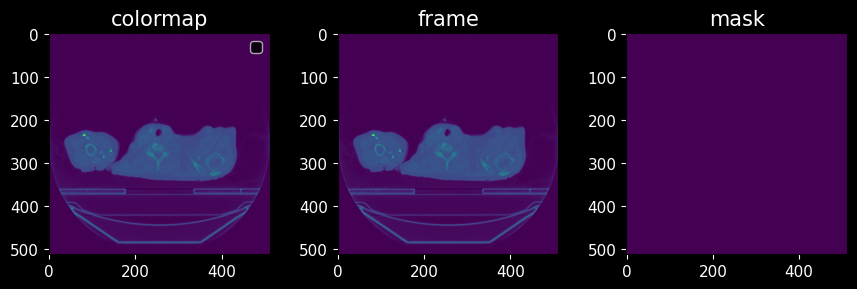

15
(512, 512) (512, 512, 4)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


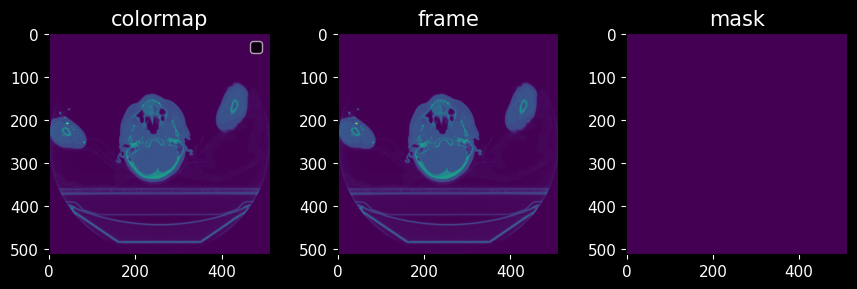

15
(512, 512) (512, 512, 4)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


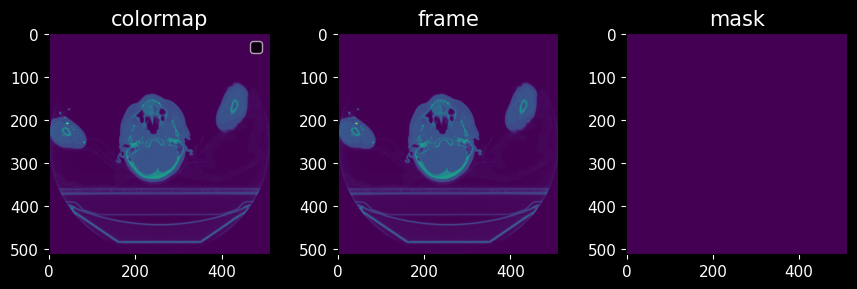

subject_id                                        LCTSC-Train-S3-009
serie                                                              0
segmentation_id                           1.000000-.simplified-46378
sex                                                                F
images_dir         /storage/TCIA/manifest-1557326747206/LCTSC/LCT...
nb_images                                                        115
images             [/storage/TCIA/manifest-1557326747206/LCTSC/LC...
segmentation       /storage/TCIA/manifest-1557326747206/LCTSC/LCT...
organs                [Esophagus, Heart, SpinalCord, Lung_L, Lung_R]
Name: 1, dtype: object
(512, 512, 16)
(512, 512, 16)
(512, 512, 16)
(512, 512, 16)
(512, 512, 16)
0
(512, 512) (512, 512, 4)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with 

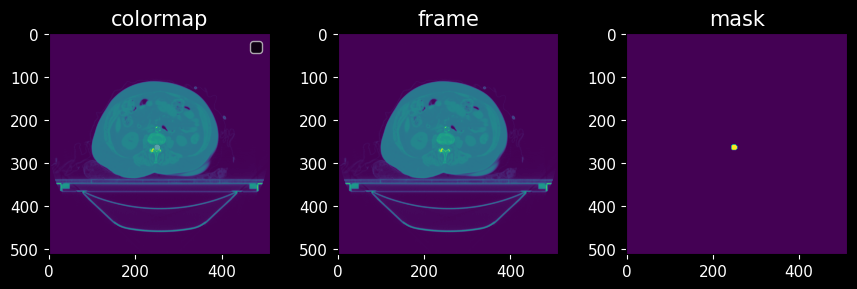

3
(512, 512) (512, 512, 4)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


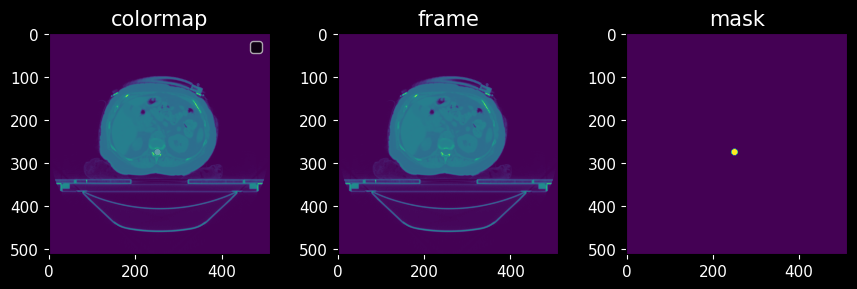

6
(512, 512) (512, 512, 4)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


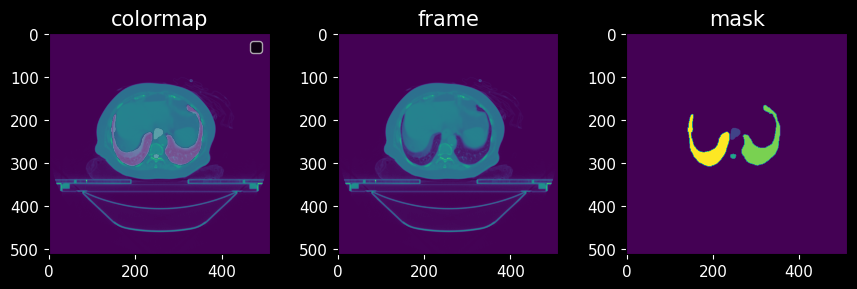

9
(512, 512) (512, 512, 4)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


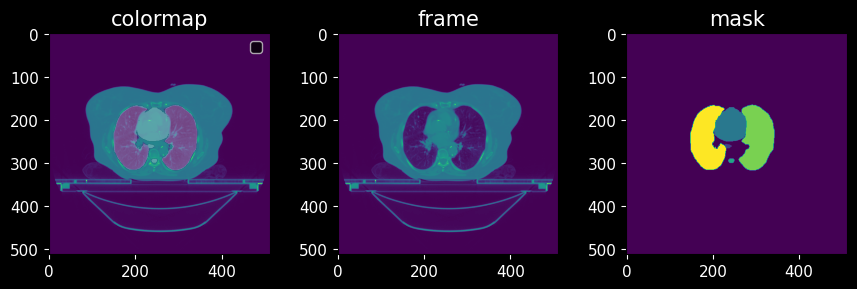

12
(512, 512) (512, 512, 4)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


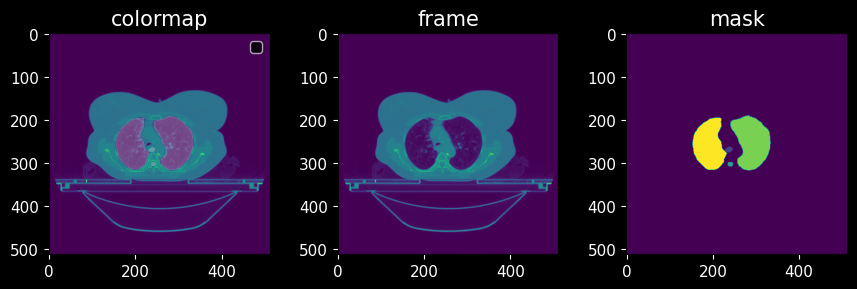

15
(512, 512) (512, 512, 4)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


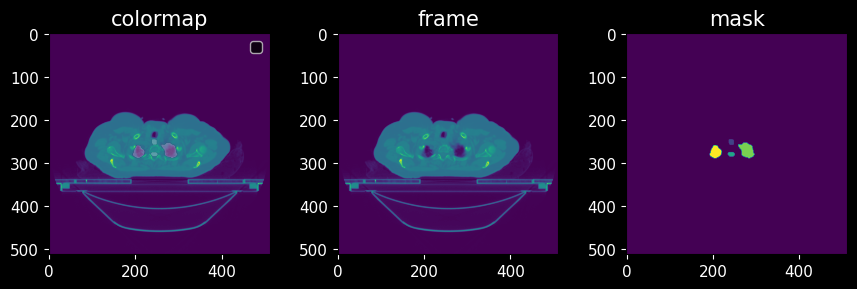

15
(512, 512) (512, 512, 4)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


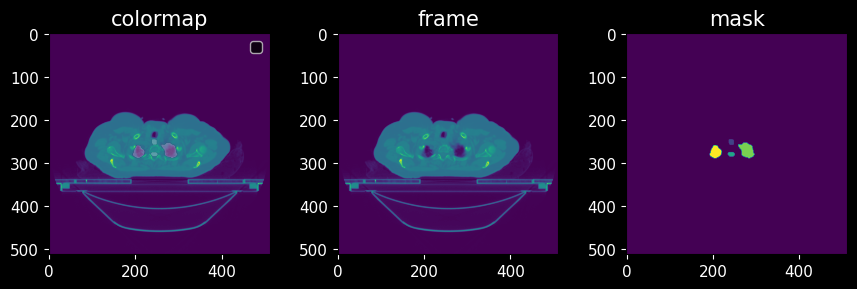

subject_id                                         LCTSC-Test-S3-103
serie                                                              0
segmentation_id                           1.000000-.simplified-29555
sex                                                                F
images_dir         /storage/TCIA/manifest-1557326747206/LCTSC/LCT...
nb_images                                                        136
images             [/storage/TCIA/manifest-1557326747206/LCTSC/LC...
segmentation       /storage/TCIA/manifest-1557326747206/LCTSC/LCT...
organs                [Esophagus, Heart, SpinalCord, Lung_L, Lung_R]
Name: 2, dtype: object
(512, 512, 16)
(512, 512, 16)
(512, 512, 16)
(512, 512, 16)
(512, 512, 16)
0
(512, 512) (512, 512, 4)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


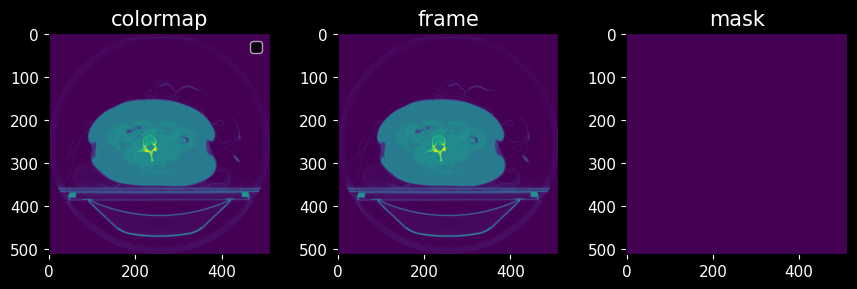

3
(512, 512) (512, 512, 4)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


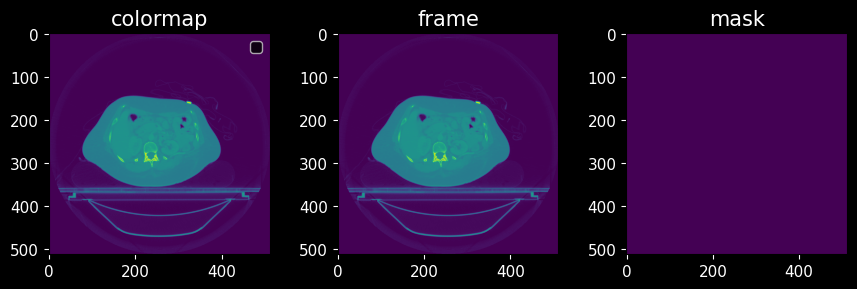

6
(512, 512) (512, 512, 4)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


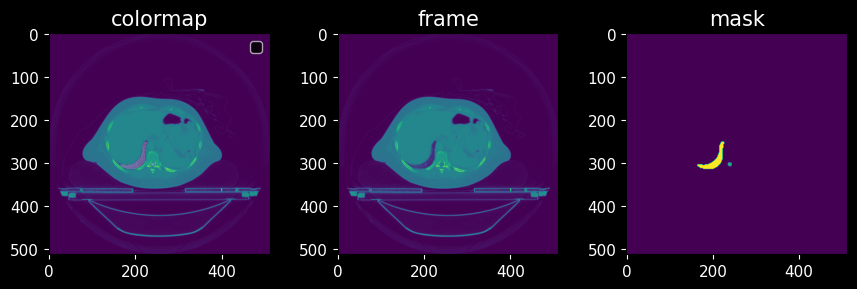

9
(512, 512) (512, 512, 4)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


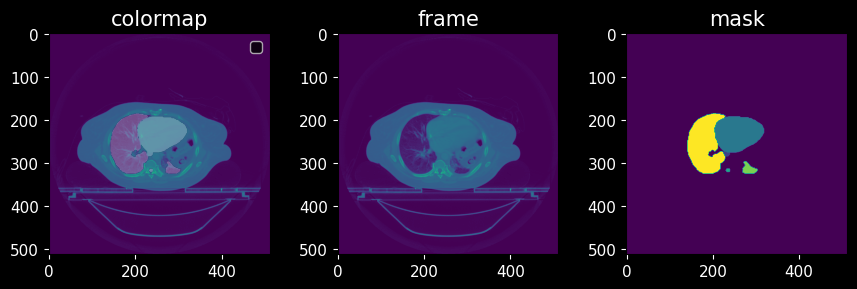

12
(512, 512) (512, 512, 4)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


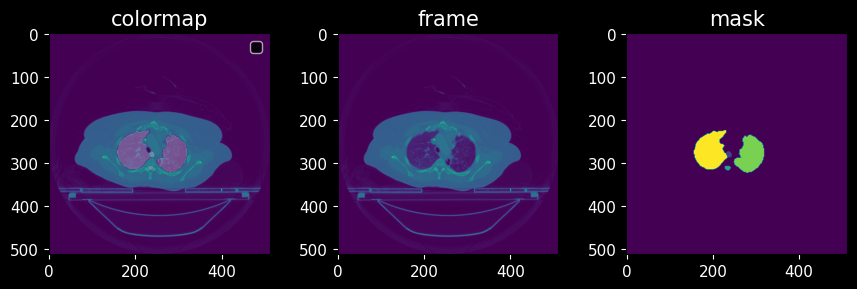

15
(512, 512) (512, 512, 4)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


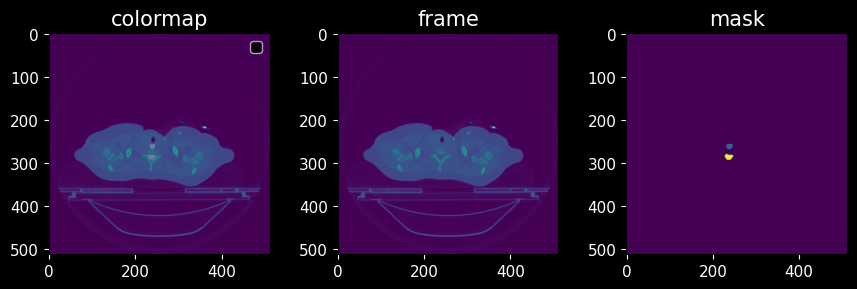

15
(512, 512) (512, 512, 4)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


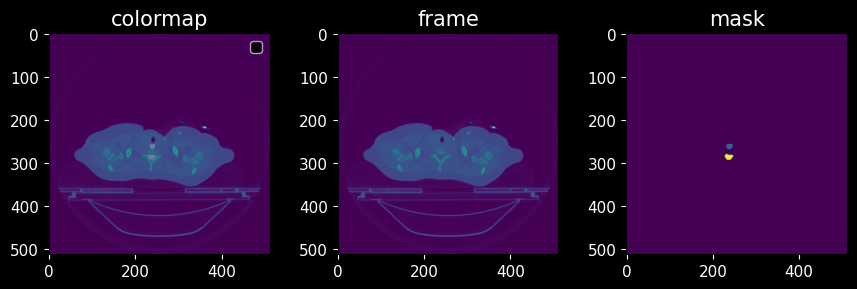

subject_id                                        LCTSC-Train-S3-010
serie                                                              0
segmentation_id                           1.000000-.simplified-76637
sex                                                                F
images_dir         /storage/TCIA/manifest-1557326747206/LCTSC/LCT...
nb_images                                                        150
images             [/storage/TCIA/manifest-1557326747206/LCTSC/LC...
segmentation       /storage/TCIA/manifest-1557326747206/LCTSC/LCT...
organs                [Esophagus, Heart, SpinalCord, Lung_L, Lung_R]
Name: 3, dtype: object
(512, 512, 16)
(512, 512, 16)
(512, 512, 16)
(512, 512, 16)
(512, 512, 16)
0
(512, 512) (512, 512, 4)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


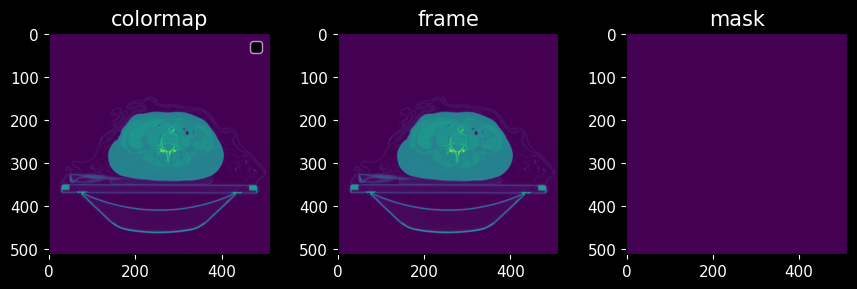

3
(512, 512) (512, 512, 4)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


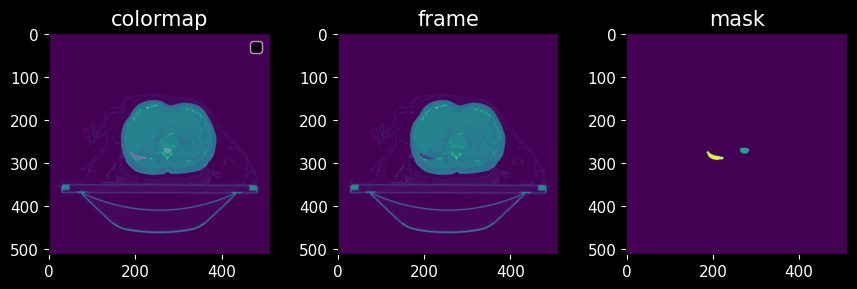

6
(512, 512) (512, 512, 4)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


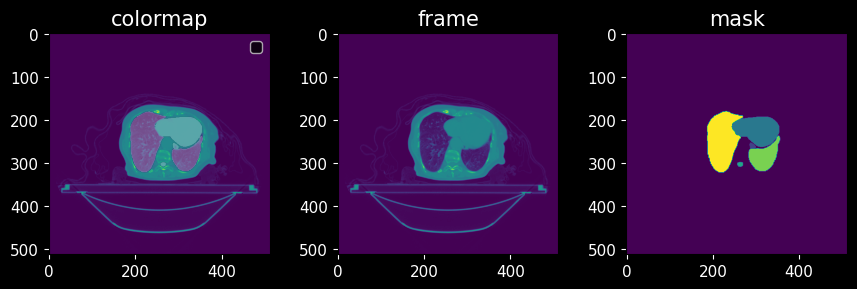

9
(512, 512) (512, 512, 4)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


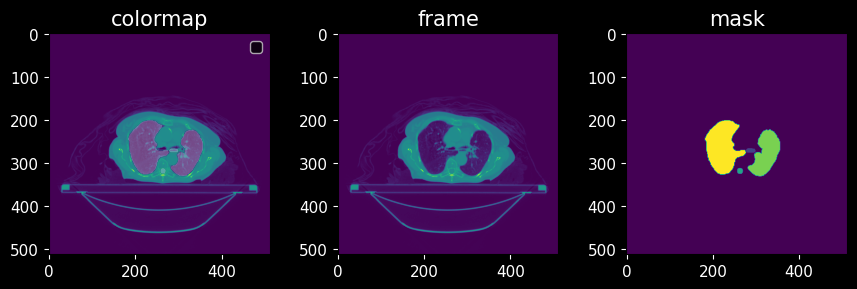

12
(512, 512) (512, 512, 4)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


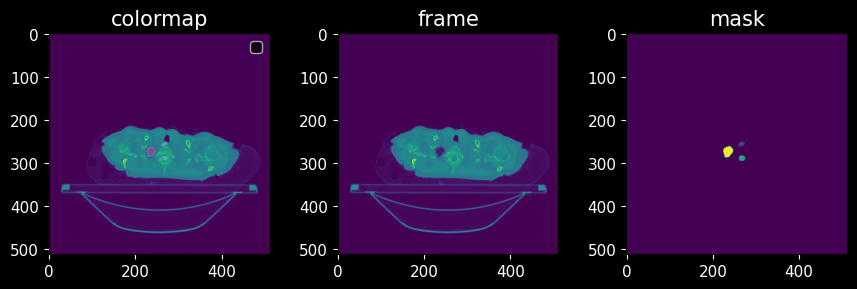

15
(512, 512) (512, 512, 4)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


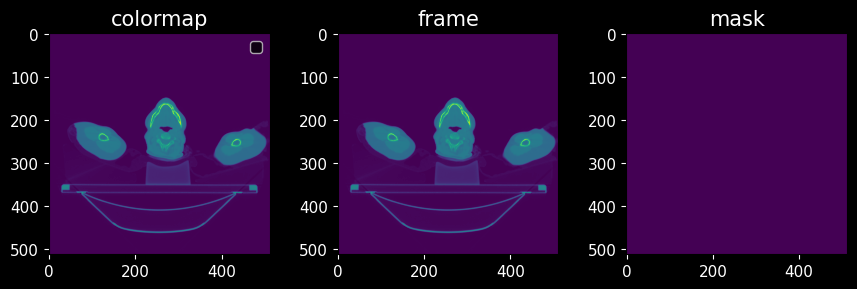

15
(512, 512) (512, 512, 4)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


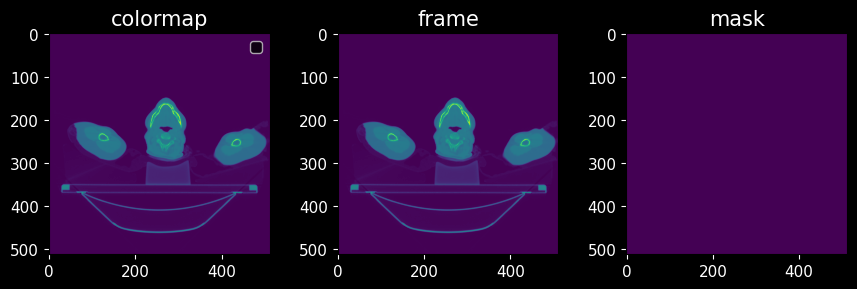

subject_id                                         LCTSC-Test-S3-104
serie                                                              0
segmentation_id                           1.000000-.simplified-93010
sex                                                                F
images_dir         /storage/TCIA/manifest-1557326747206/LCTSC/LCT...
nb_images                                                        165
images             [/storage/TCIA/manifest-1557326747206/LCTSC/LC...
segmentation       /storage/TCIA/manifest-1557326747206/LCTSC/LCT...
organs                [Esophagus, Heart, SpinalCord, Lung_L, Lung_R]
Name: 4, dtype: object
(512, 512, 16)
(512, 512, 16)
(512, 512, 16)
(512, 512, 16)
(512, 512, 16)
0
(512, 512) (512, 512, 4)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


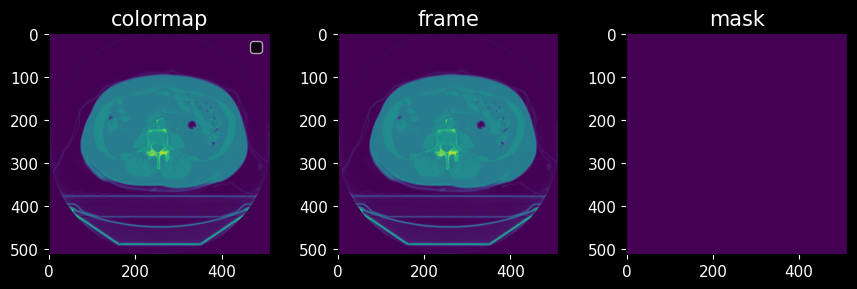

3
(512, 512) (512, 512, 4)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


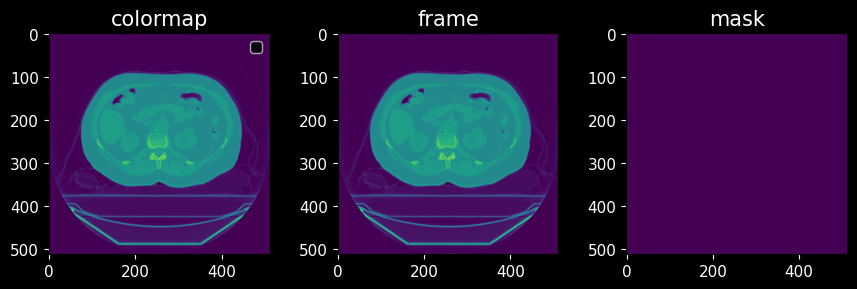

6
(512, 512) (512, 512, 4)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


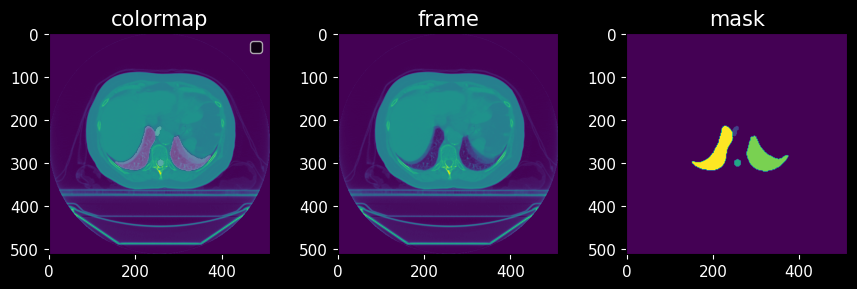

9
(512, 512) (512, 512, 4)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


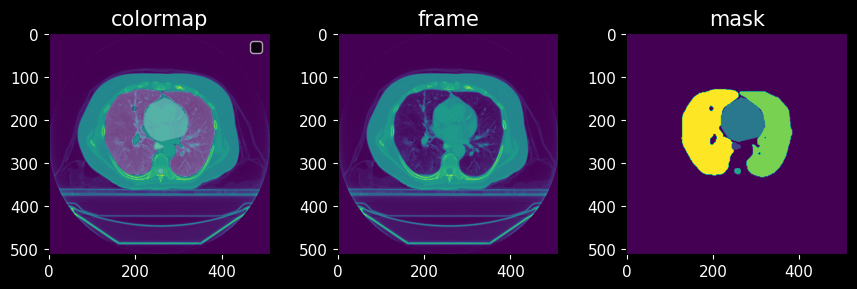

12
(512, 512) (512, 512, 4)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


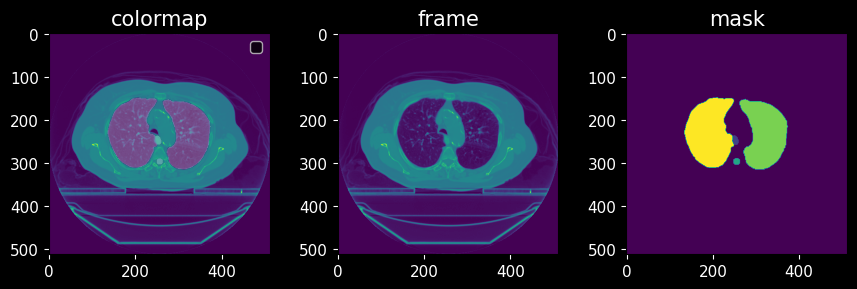

15
(512, 512) (512, 512, 4)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


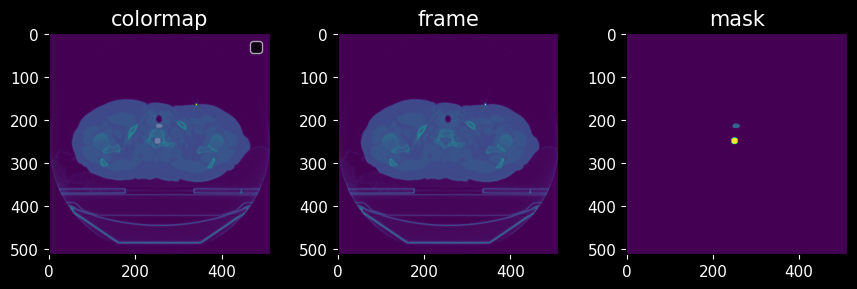

15
(512, 512) (512, 512, 4)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


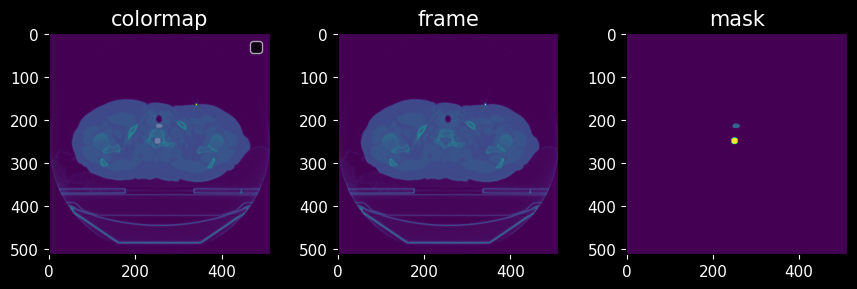

In [18]:
import math

from rt_utils import RTStructBuilder

from utils import plot_utils

n = 16
for i in range(5):
    print(df.loc[i])
    frames = df.loc[i, 'images']
    indexes = list(range(0, len(frames), len(frames) // n))[:n]
    
    try:
        seg = RTStructBuilder.create_from(
            dicom_series_path = df.loc[i, 'images_dir'],
            rt_struct_path    = df.loc[i, 'segmentation']
        )
    except:
        print('Error with {}'.format(df.loc[i, 'segmentation']))
        continue
    
    mask = None
    for i, organ in enumerate(seg.get_roi_names()):
        try:
            m = seg.get_roi_mask_by_name(organ)[:, :, ::1]
            m = m[:, :, indexes]
            print(m.shape)
            if mask is None: mask = np.zeros(m.shape)
            mask[np.where(m)] = i + 1
        except AttributeError:
            print('Error with organ {}'.format(organ))
            continue
    
    """plot_multiple(
        ** {
            'Frame #{}'.format(idx) : dcm.dcmread(frames[idx]).pixel_array for idx in indexes
        },
        ** {
            'Mask #{}'.format(j) : mask[:, :, j] for j in range(len(indexes))
        },
        plot_type = 'imshow', ncols = int(math.sqrt(n))
    )"""
    
    for idx in list(range(0, len(indexes), 3)) + [len(indexes) - 1]:
        print(idx)
        mask_alpha  = mask[:, :, idx : idx + 1]
        mask_alpha = np.repeat(mask_alpha, 3, axis = -1)
        mask_alpha = np.concatenate([mask_alpha, 0.25 * (mask_alpha[:, :, :1] != 0)], axis = -1).astype(np.float32)

        f = dcm.dcmread(frames[indexes[idx]]).pixel_array
        print(f.shape, mask_alpha.shape)
        plot_utils.plot_multiple(
            colormap = {'x' : {'frame' : f / np.max(f), 'mask' : mask_alpha}},
            frame = f, mask = mask_alpha[:, :, 0].astype(np.int32),
            plot_type = 'imshow', size = 3, ncols = 3
        )


In [ ]:
for _ in range(1):
    for idx in list(range(0, len(indexes), 3)) + [len(indexes) - 1]:
        print(idx)
        mask_alpha = mask[:, :, ::1]
        mask_alpha = np.repeat(mask_alpha[:, :, idx : idx + 1], 3, axis = -1)
        mask_alpha = np.concatenate([mask_alpha, 0.25 * (mask_alpha[:, :, :1] != 0)], axis = -1).astype(np.float32)

        f = dcm.dcmread(frames[indexes[idx]]).pixel_array
        print(f.shape, mask_alpha.shape)
        plot_utils.plot_multiple(
            colormap = {'x' : {'frame' : f / np.max(f), 'mask' : mask_alpha}},
            frame = f, mask = mask_alpha[:, :, 0].astype(np.int32),
            plot_type = 'imshow', size = 3, ncols = 3
        )


In [50]:
skin = seg.get_roi_mask_by_name('Skin')
print(skin.shape)

(512, 512, 729)


In [39]:
import os

for index in indexes:
    print(index, os.path.basename(frames[index]))


0 1-001.dcm
29 1-030.dcm
58 1-059.dcm
87 1-088.dcm
116 1-117.dcm
145 1-146.dcm
174 1-175.dcm
203 1-204.dcm
232 1-233.dcm
261 1-262.dcm
290 1-291.dcm
319 1-320.dcm
348 1-349.dcm
377 1-378.dcm
406 1-407.dcm
435 1-436.dcm
464 1-465.dcm
493 1-494.dcm
522 1-523.dcm
551 1-552.dcm
580 1-581.dcm
609 1-610.dcm
638 1-639.dcm
667 1-668.dcm
696 1-697.dcm


### Test 3D segmentation plots

In [ ]:
from rt_utils import RTStructBuilder

seg_file = df.loc[0, 'label']

seg = RTStructBuilder.create_from(
    dicom_series_path = os.path.dirname(df.loc[0, 'images'][0]),
    rt_struct_path = seg_file[0]
)
print(seg)

In [ ]:
print(seg.get_roi_names())

mask = seg.get_roi_mask_by_name('Heart')
print(mask.shape)

In [ ]:
plot_multiple(** {
    'Slice #{}'.format(i) : mask[:, :, i] for i in range(0, mask.shape[2], mask.shape[2] // 16)
}, plot_type = 'imshow', ncols = 4)


In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')

all_x, all_y, all_z, colors = [], [], [], []
for i, organ in enumerate(seg.get_roi_names()):
    print('Mask for organ {}...'.format(organ))
    try:
        mask = seg.get_roi_mask_by_name(organ)
    except AttributeError:
        print('Error for organ {}'.format(organ))
        continue

    y, x, z = np.where(mask)
    all_x.extend(x)
    all_y.extend(y)
    all_z.extend(z)
    colors.extend([i] * len(x))
ax.scatter(np.array(all_x), np.array(all_y), np.array(all_z), c = colors)
ax.set_aspect('equal')
plt.show()
    

In [ ]:
from matplotlib import colors

base_colors = list(colors.BASE_COLORS.keys())

c_idx = 0
voxels, colors = None, None
for i, organ in enumerate(seg.get_roi_names()):
    if organ == 'Skin': continue
    print('Mask for organ {}...'.format(organ))
    try:
        mask = seg.get_roi_mask_by_name(organ)
    except AttributeError:
        print('Error for organ {}'.format(organ))
        continue

    voxels = mask if voxels is None else (mask | voxels)
    if colors is None: colors = np.empty(voxels.shape, dtype = object)
    colors[mask] = base_colors[c_idx % len(base_colors)]
    c_idx += 1

In [ ]:
import matplotlib.pyplot as plt

sx, sy, sz = 3, -3, 1
ax = plt.figure(figsize = (10, 10)).add_subplot(projection = '3d')

ax.voxels(voxels[::sy, ::sx, ::sz].astype(bool), facecolors = colors[::sy, ::sx, ::sz])
ax.set_aspect('equal')

plt.show()

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(projection = '3d')

ax.scatter(x, y, z)
ax.set_aspect('equal')
plt.show()

In [ ]:
help(ax.voxels)

## Test TotalSegmentator

In [ ]:
import os
import dicom2nifti

dir_name = '../TCIA/manifest-1557326747206/LCTSC/LCTSC-Train-S3-012/05-04-2004-NA-NM PET SCAN RADIATION-26270/1.000000-NA-64131'
out_name = 'test_nifti'

dir_name = '../TCIA/manifest-1647979711903/Pediatric-CT-SEG/Pediatric-CT-SEG-FD1B2AC2/01-29-2004-NA-CT-90529/444.000000-CT-64434'
out_name = 'test_nifti2'
os.makedirs(out_name, exist_ok = True)

dicom2nifti.convert_directory(dir_name, out_name)
print(os.listdir(out_name))

In [ ]:
import nibabel as nib

from utils import plot_multiple

image = nib.load('test_nifti2/444_ct.nii.gz').get_fdata()
print('Shape : {}'.format(image.shape))

plot_multiple(
    ** {'Slice {}'.format(i) : image[:, :, i] for i in range(0, image.shape[2], image.shape[2] // 16)},
    ncols = 4, plot_type = 'imshow', cmap = 'magma'
)

In [ ]:
!TotalSegmentator -i test_nifti/1_.nii.gz -o test_segmentations